In [57]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid", context="notebook")

import statsmodels.api as sm

from zipfile import ZipFile

import warnings
warnings.filterwarnings("ignore")

# Data Preparing

In [83]:
ZipFile("transactions.csv.zip", "r").extractall()
data = pd.read_csv("transactions.csv")

In [54]:
df = data.copy()

- Data set has duplications in terms of `ga_transactionid`. If it represents a unique transaction, different interests of products, and interests coming different channels in same transaction are possible. Therefore, we cleaned duplicates in two scenarios: clening based on `subset=["ga_transactionid", "ga_products"]` cleaning and cleaning based on `subset=["ga_transactionid", "ga_channels"]`

- We pivoted two different tables, one of which represents interests to products on daily basis, and other one reflects interests coming from different channels.

- We observed null values in channels data, and we discarded them from result set.

- Date 18.10.2021 seemed not to inclue valid records, so we dropped last day.

- Since, data set spends large amount of memory, it is better to save it as a temporary file, and clean all other variables to gain free memory. 

In [7]:
df["ga_channels"] = df["ga_channels"].fillna("NA")
df["ga_datehour"] = df["ga_datehour"].astype("str")

f = df.ga_datehour
df["date"] = f.str.slice(0,4)+"-"+f.str.slice(4,6)+"-"+f.str.slice(6,8)
df["hour"] = f.str.slice(8,10).astype("int")
df["date"] = df["date"].astype("datetime64")

prod = df.drop_duplicates(subset=["ga_transactionid", "ga_products"],
                          ignore_index=True)

channel = df.drop_duplicates(subset=["ga_transactionid", "ga_channels"],
                             ignore_index=True)

prod_pvt = pd.pivot_table(df, index="date",
                          columns="ga_products",
                          values="ga_itemquantity",
                          aggfunc=np.sum)

channel_pvt = pd.pivot_table(df, index="date",
                             columns="ga_channels",
                             values="ga_itemquantity",
                             aggfunc=np.sum)

prod_pvt.drop(prod_pvt.index[-1], inplace=True)
channel_pvt.drop(channel_pvt.index[-1], inplace=True)

prod_pvt["daily_sum"] = prod_pvt.sum(axis=1)

time_data = pd.concat([prod_pvt, channel_pvt], axis=1)
time_data.drop(columns="NA", inplace=True)
time_data.to_csv("time_data.csv", index="date")

del channel, channel_pvt, data, df, f, prod_pvt, prod

In [9]:
time_data = pd.read_csv("time_data.csv",
                        index_col="date")

In [10]:
dfeco = pd.read_csv("economic_calendar.csv",
                    index_col="date")
dfvar = pd.read_csv("economic_variables.csv",
                    index_col="date")

In [55]:
df = time_data.copy()
df.index = df.index.astype("datetime64[ns]")
dfvar.index = dfvar.index.astype("datetime64[ns]")
dfeco.index = dfeco.index.astype("datetime64[ns]")

# General Appearance

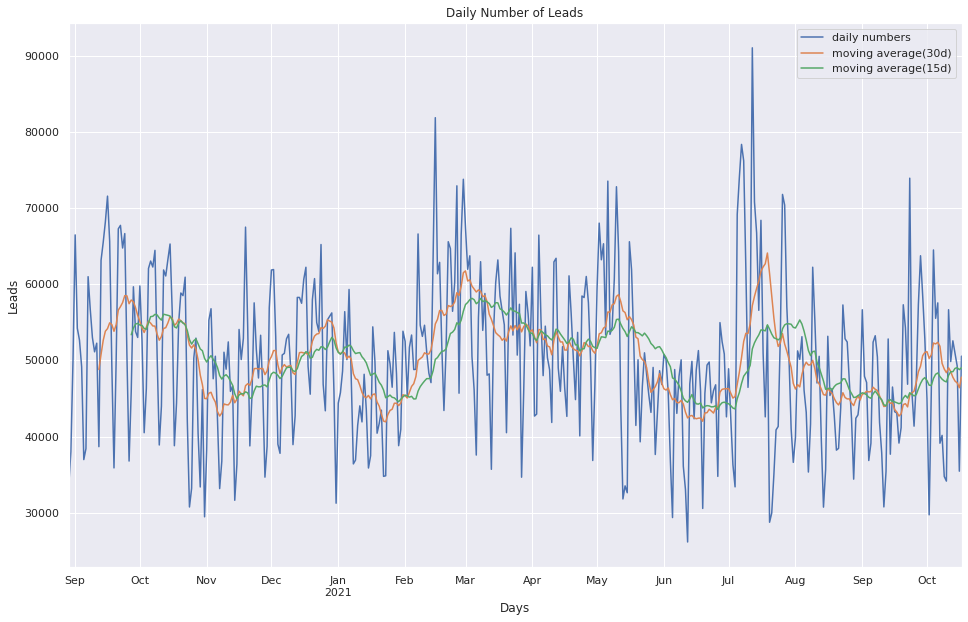

In [56]:
fig, ax = plt.subplots(1, 1, figsize=(16, 10))
df["daily_sum"].plot()
df["daily_sum"].rolling(15).mean().plot()
df["daily_sum"].rolling(30).mean().plot()
ax.set_xlabel("Days")
ax.set_ylabel("Leads")
ax.set_title("Daily Number of Leads")
ax.legend(["daily numbers", "moving average(30d)", "moving average(15d)"])
plt.show()

From the plot above data set has 3-month-basis seasonal variation roughly.

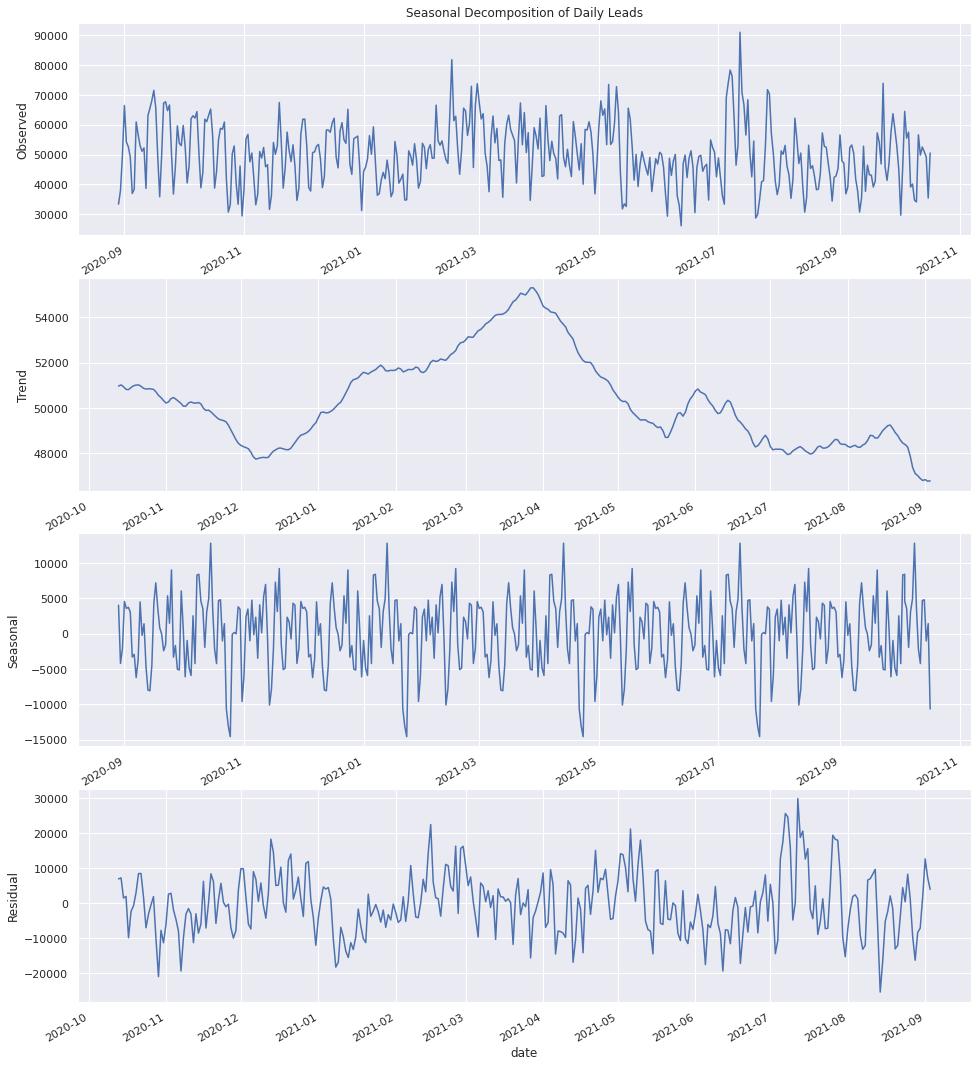

In [76]:
fig, ax = plt.subplots(4, 1, figsize=(16, 20))
ddf = sm.tsa.seasonal_decompose(df["daily_sum"], freq=90)

ddf.observed.plot(ax=ax[0], legend=False)
ax[0].set_title("Seasonal Decomposition of Daily Leads")
ax[0].set_ylabel("Observed")
ddf.trend.plot(ax=ax[1], legend=False)
ax[1].set_ylabel("Trend")
ddf.seasonal.plot(ax=ax[2], legend=False)
ax[2].set_ylabel("Seasonal")
ddf.resid.plot(ax=ax[3], legend=False)
ax[3].set_ylabel("Residual")
plt.show()

From the seasonal decomposition of the daily sum variable, nearly 3-month-basis is clearer, and the data has a trend decreasing at second half, with a peak in April.  

# Interest Rate and Inflation

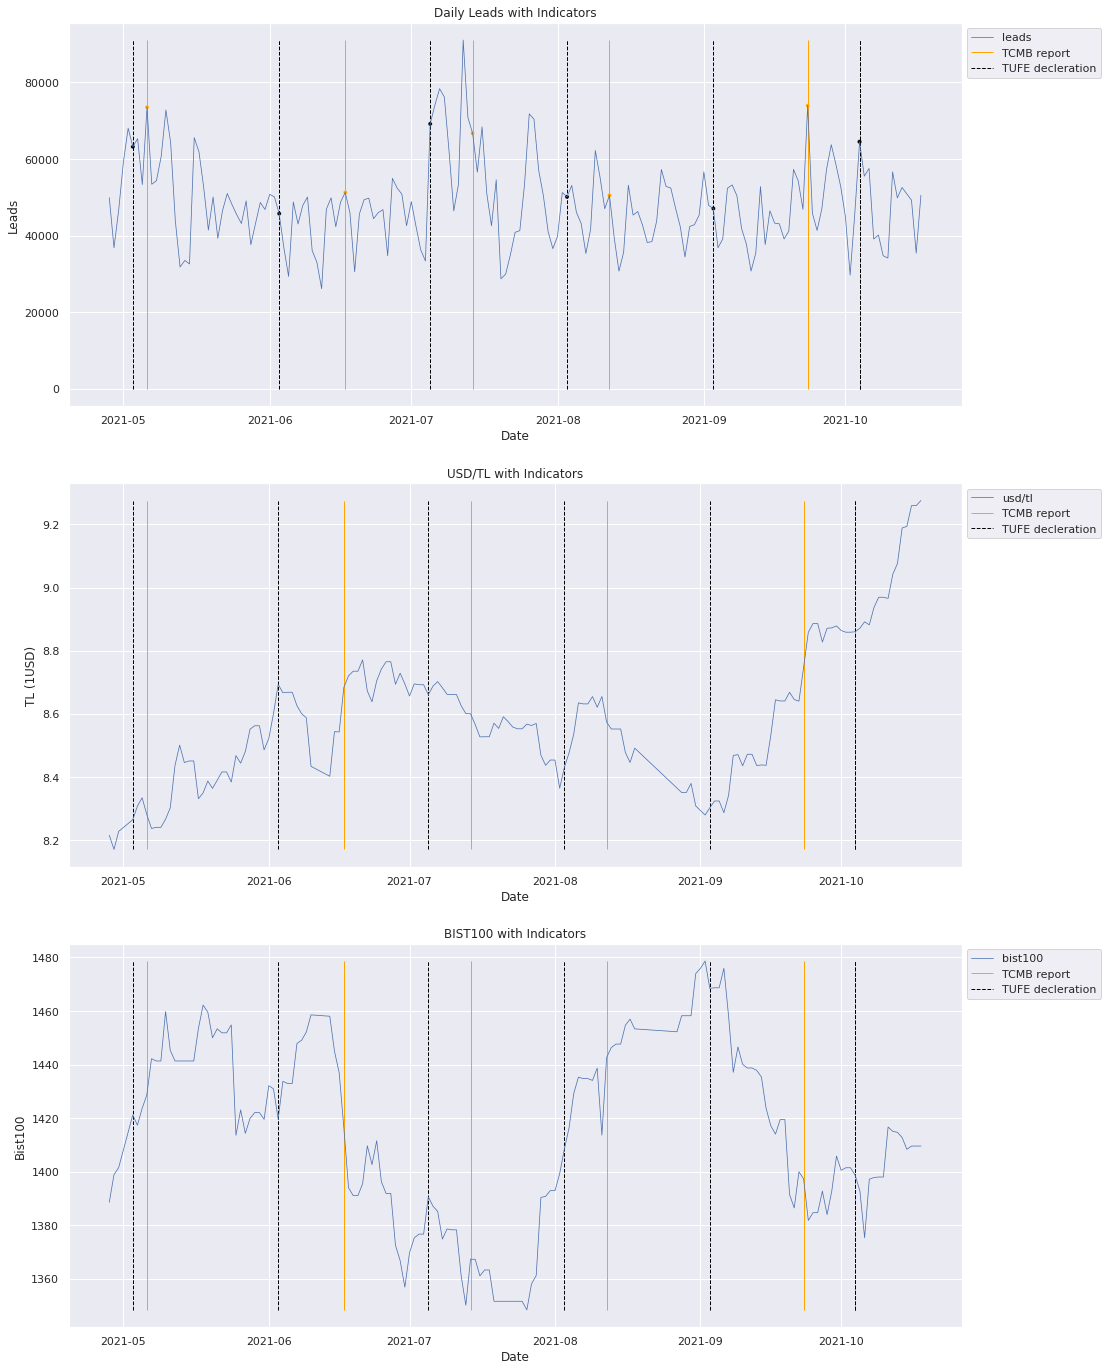

In [68]:
tr = dfeco["country"]=="Türkiye"
rf = dfeco["indicator"]=="TCMB Haftalık Repo Gösterge Faiz Oranı"
tu = dfeco["indicator"]=="Tüketici Fiyat Endeksi(Aylık)" 

repo = dfeco.loc[tr&rf, ["indicator"]]
tufe = dfeco.loc[tr&tu, ["indicator"]]

repo["repo_interest"] = 1
tufe["tufe_index"] = 1
df = df.merge(repo[["repo_interest"]],
              how="left", on="date")
df = df.merge(tufe[["tufe_index"]],
              how="left", on="date")
bistusd = dfvar[~dfvar.index.duplicated(keep="last")]

fig, ax = plt.subplots(3, 1, figsize=(16, 24))
g1 = sns.lineplot(x=df["2021-04-28":].index,
                  y=df["2021-04-28":]["daily_sum"].values,
                  ax=ax[0], size=8, label="leads", legend=False)
g2 = sns.scatterplot(x=df[df["repo_interest"].notna()].index,
                     y=df.loc[df["repo_interest"].notna(), "daily_sum"].values,
                     ax=ax[0], size=10, color="orange", legend=False)
g3 = sns.scatterplot(x=df[df["tufe_index"].notna()].index,
                     y=df.loc[df["tufe_index"].notna(), "daily_sum"].values,
                     ax=ax[0], size=10, color="black", legend=False)
g4 = sns.lineplot(x=bistusd.index,
                  y=bistusd["usdtry"].values,
                  ax=ax[1],
                  size=8, label="usd/tl", legend=False)
g5 = sns.lineplot(x=bistusd.index,
                  y=bistusd["bist100"].values,
                  ax=ax[2],
                  size=8, label="bist100", legend=False)
ax[0].set_title("Daily Leads with Indicators")
ax[0].set_xlabel("Date")
ax[0].set_ylabel("Leads")
ax[0].vlines(x=df[df["repo_interest"].notna()].index,
             ymin=0,
             ymax=df["2021-04-28":]["daily_sum"].max(),
             color="orange", lw=1, label="TCMB report")
ax[0].vlines(x=df[df["tufe_index"].notna()].index,
             ymin=0,
             ymax=df["2021-04-28":]["daily_sum"].max(),
             color="black", ls="--", lw=1, label="TUFE decleration")
ax[0].legend(bbox_to_anchor=(1.0, 1), loc="upper left")
ax[1].set_title("USD/TL with Indicators")
ax[1].set_xlabel("Date")
ax[1].set_ylabel("TL (1USD)")
ax[1].vlines(x=df[df["repo_interest"].notna()].index,
             ymin=bistusd["usdtry"].min(),
             ymax=bistusd["usdtry"].max(),
             color="orange", lw=1, label="TCMB report")
ax[1].vlines(x=df[df["tufe_index"].notna()].index,
             ymin=bistusd["usdtry"].min(),
             ymax=bistusd["usdtry"].max(),
             color="black", ls="--", lw=1, label="TUFE decleration")
ax[1].legend(bbox_to_anchor=(1.0, 1), loc="upper left")
ax[2].set_title("BIST100 with Indicators")
ax[2].set_xlabel("Date")
ax[2].set_ylabel("Bist100")
ax[2].vlines(x=df[df["repo_interest"].notna()].index,
             ymin=bistusd["bist100"].min(),
             ymax=bistusd["bist100"].max(),
             color="orange", lw=1, label="TCMB report")
ax[2].vlines(x=df[df["tufe_index"].notna()].index,
             ymin=bistusd["bist100"].min(),
             ymax=bistusd["bist100"].max(),
             color="black", ls="--", lw=1, label="TUFE decleration")
ax[2].legend(bbox_to_anchor=(1.0, 1), loc="upper left")
plt.show()

- The above graph sets reflect the relationship between daily lead numbers and the releasing dates of the most important indicators of Turkish Economy. Orange vertical lines represent the Turkish Central Bank's monthly report days and the blue dashed vertical lines are for the inflation rate anounces. 

- According to first graph there are certain declines of daily lead numbers  after all interest rate declaration. On the other hand one can consider that there are usually peaks before the Turkish Central Bank meeting. Most probably the products are financial and interest rate sensitive.

- Probably consumers still find the costs of financial products higher, or above their expectations. The financial consumers hope of more interest rate cuts following meetings. 

- Of course there are a lot of factors influencing foreign currency but, the August meeting of the Turkish Central Bank is the most impactful on USD/TL price, and the September inflation rate decleration points the most valueable day of TL in the summer period.  

# Interest Rate and Daily Leads

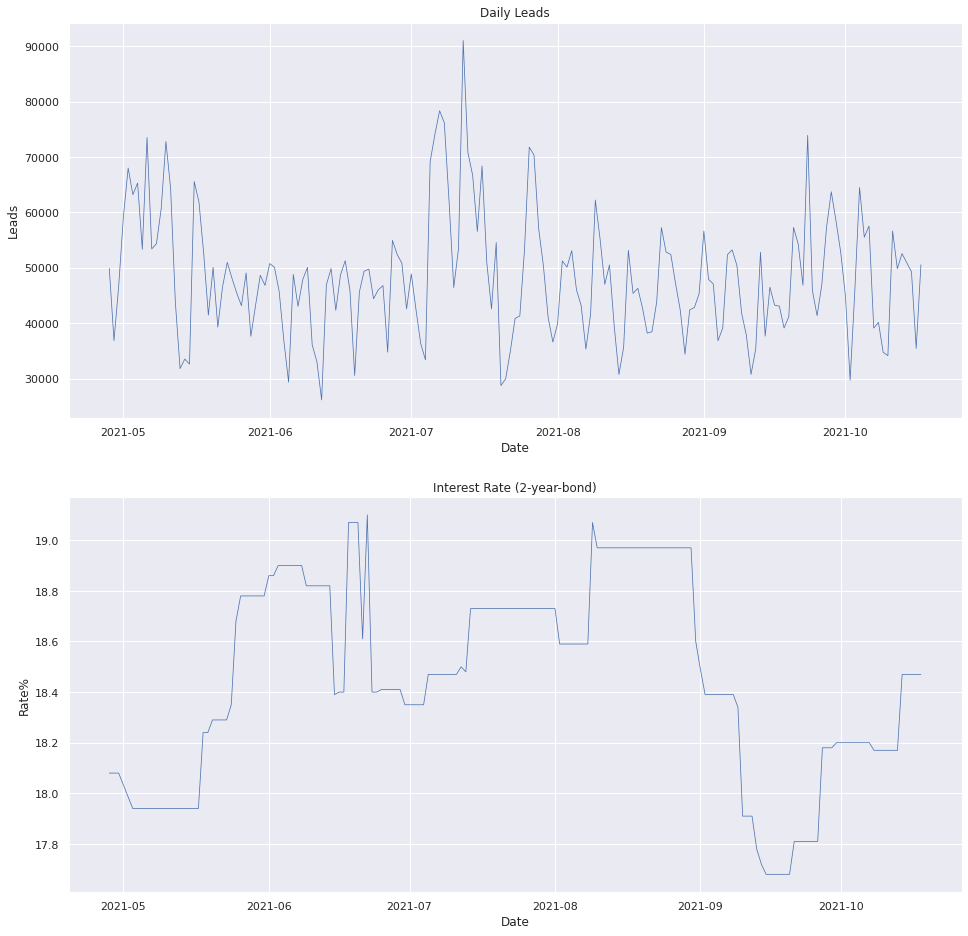

In [78]:
interest = dfvar[~dfvar.index.duplicated(keep="last")]

fig, ax = plt.subplots(2, 1, figsize=(16, 16))
g1 = sns.lineplot(x=df["2021-04-28":].index,
                  y=df["2021-04-28":]["daily_sum"].values,
                  ax=ax[0], size=8, label="leads", legend=False)
g2 = sns.lineplot(x=interest.index,
                  y=interest["faiz"].values,
                  ax=ax[1], size=8, label="interest-rate", legend=False)
ax[0].set_title("Daily Leads")
ax[0].set_xlabel("Date")
ax[0].set_ylabel("Leads")

ax[1].set_title("Interest Rate (2-year-bond)")
ax[1].set_xlabel("Date")
ax[1].set_ylabel("Rate%")

plt.show()

The 2-year bond interest rates may be considered as general interest rate indicator of Turkish economy. One can be obtain from the graph above the increasing trends of interest rate, in nearly June and September 2021, nearly match the decreasing seasonal trends of daily lead numbers.    